In [2]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from simplified_monorotor import Monorotor
import plotting
import testing
import trajectories

pylab.rcParams['figure.figsize'] = 10,10

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# PD controller 

#### Implement PD controller

Implement the PD Controller math in `thrust_control`:

$$
\begin{align}
e &= z_{\text{target}} - z_{\text{actual}} \\
\dot{e} &= \dot{z}_{\text{target}} - \dot{z}_{\text{actual}} \\
\bar{u}_1 &= k_p e + k_d \dot{e} \\
u_1 &= m(g - \bar{u}_1)
\end{align}
$$

In [5]:
class PDController:
    
    def __init__(self, k_p, k_d, m):
        self.k_p = k_p
        self.k_d = k_d
        self.vehicle_mass = m
        self.g = 9.81
    
    def thrust_control(self,
                z_target, 
                z_actual, 
                z_dot_target, 
                z_dot_actual,
                z_dot_dot_ff=0.0): # IGNORE this for now.
        
        # Error calculation
        error = z_target - z_actual
        
        # error_dot calculation
        error_dot = z_dot_target - z_dot_actual
        
        # U_bar calculation
        u_bar = self.k_p * error + self.k_d * error_dot
        
        # Thrust calculation
        u = self.vehicle_mass * (self.g - u_bar)
        
        return u
    
testing.pd_controller_test(PDController, feed_forward=False)

Tests pass


#### Adjust parameters

Start by running the code below with K_D = 0.0. This will remind you what a P-controlled trajectory looks like. Then try slowly increasing K_D to 0.5, 1.0, 2.0, etc... 

What value of K_D gives a reasonable trajectory?

Is there a problem with setting K_D too high? 

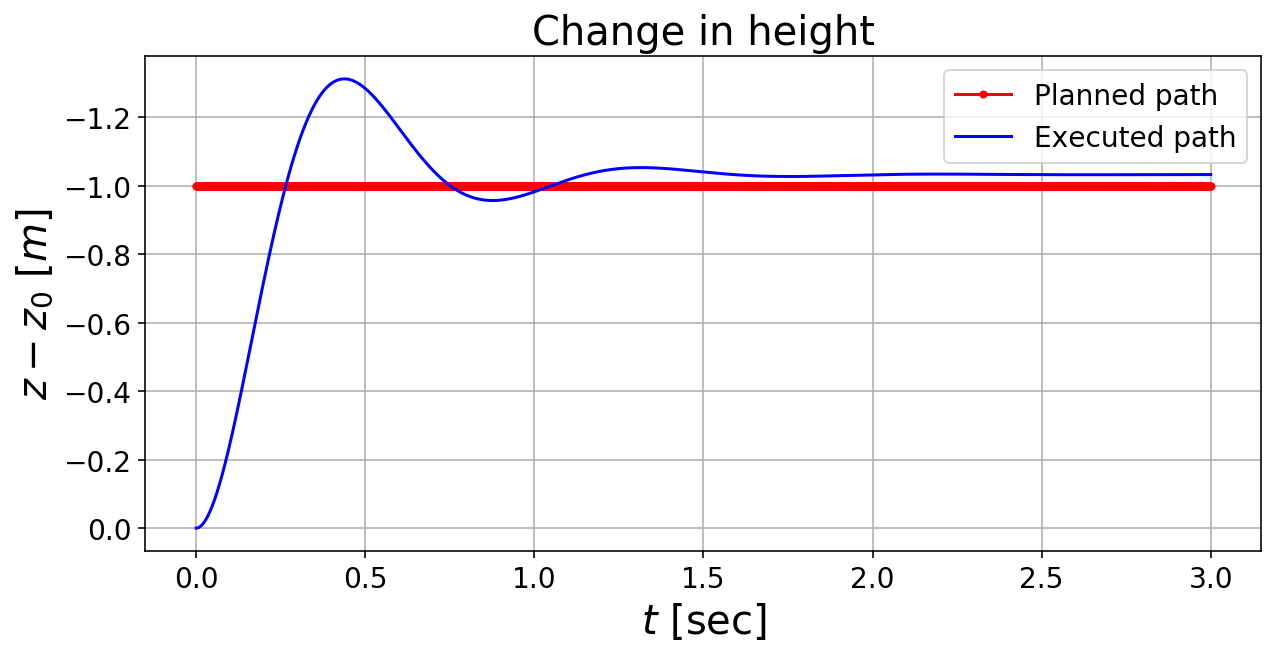

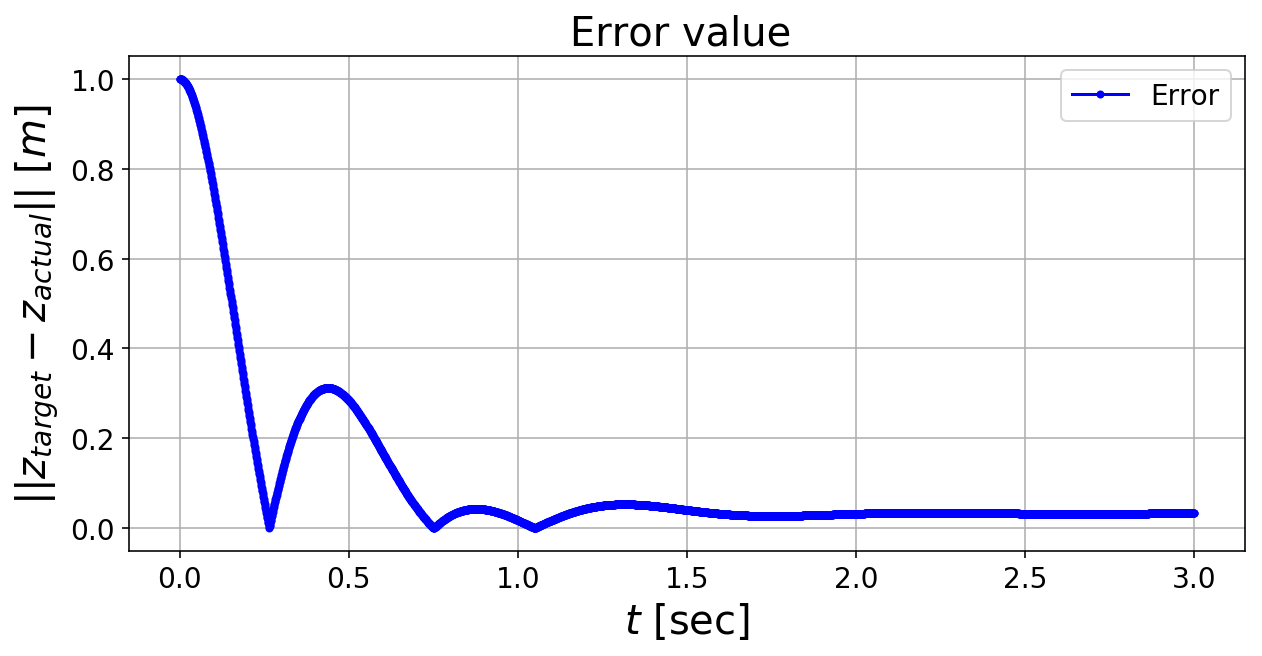

In [34]:
MASS_ERROR = 1.2
K_P = 50.0
K_D = 5.0

# preparation
drone = Monorotor()
perceived_mass = drone.m * MASS_ERROR
controller = PDController(K_P, K_D, perceived_mass)

# generate trajectory
total_time = 3.0
dt = 0.001
t=np.linspace(0.0,total_time,int(total_time/dt))
z_path= -np.ones(t.shape[0])
z_dot_path = np.zeros(t.shape[0])

# run simulation
history = []
for z_target, z_dot_target in zip(z_path, z_dot_path):
    z_actual = drone.z
    z_dot_actual = drone.z_dot
    u = controller.thrust_control(z_target, z_actual, 
                                  z_dot_target, z_dot_actual)
    drone.thrust = u
    drone.advance_state(dt)
    history.append(drone.X)
    
# generate plots
z_actual = [h[0] for h in history]
plotting.compare_planned_to_actual(z_actual, z_path, t)    